## **0. Introduction**

This notebook serves the purpose of exploring the data used in the master thesis. For now I will look into the dataset from [Kosti et al., 2017](https://openaccess.thecvf.com/content_cvpr_2017/papers/Kosti_Emotion_Recognition_in_CVPR_2017_paper.pdf), the data can be requested [here](https://docs.google.com/forms/d/e/1FAIpQLScXwxhEZu7RpHwgiRqVfb09GzHSSyIm64hJQMgHSLm75ltsFQ/viewform).

There are different types of image folders. At first I will investigate the "emodb_small" folder. This contains mostly images, in which the face is clearly visible.

In [1]:
import os
os.chdir('/mnt/c/Users/janos/OneDrive/Desktop/Master_thesis/kosti/emodb_small/images')

In [2]:
len(os.listdir())

866

The emod_small folder contains 861 images.

In [3]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

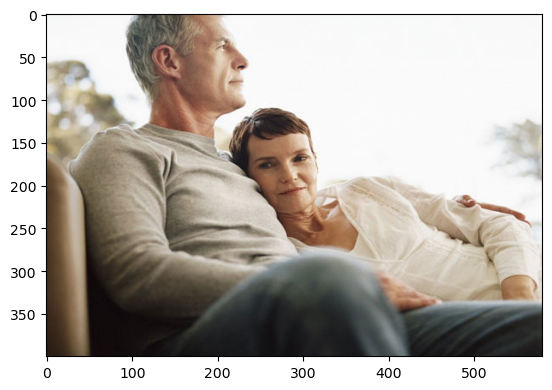

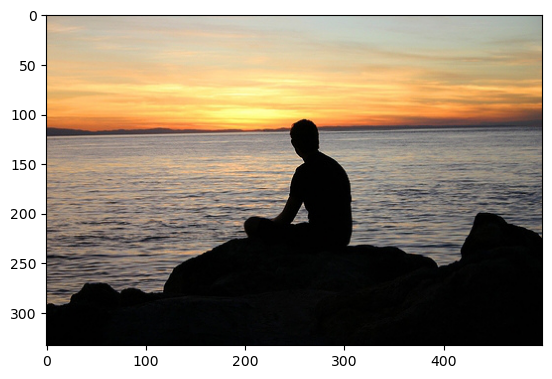

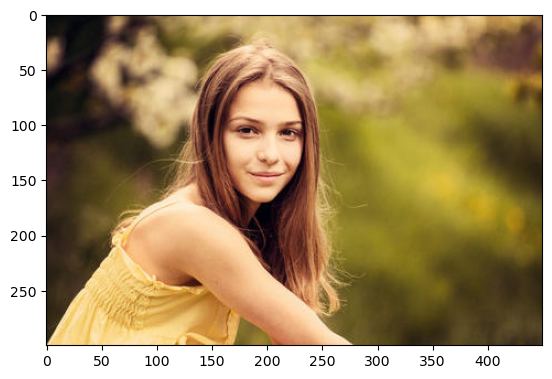

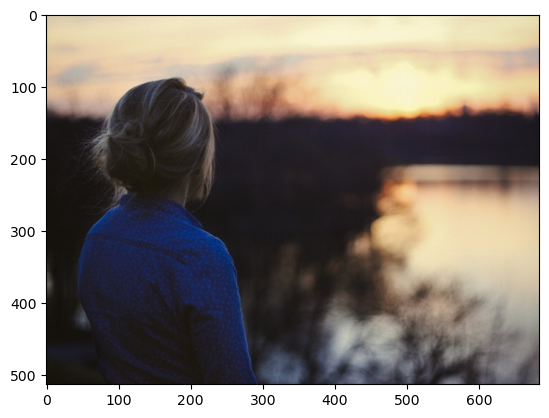

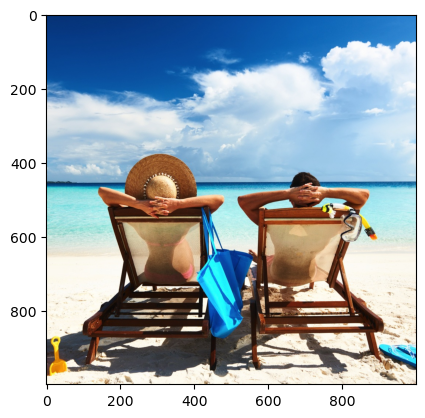

In [4]:
j=0
X = []
for img in os.listdir():
    image = mpimg.imread(img)
    plt.imshow(image)
    plt.show()
    j = j +1
    X.append(img)
    if j == 5:
        break
        
        

In [5]:
X

['007eear5kx5qhbzewz.jpg',
 '00qbvchuemlwx6muhk.jpg',
 '0185j147iy2lwsq0p9.jpg',
 '01qhe9raflmm17xf7k.jpg',
 '02hroo5r4kiukih6ig.jpg']

In [6]:
import torch

In [7]:
from PIL import Image
from torchvision import transforms

Salience extraction. The following is heavily inspired by this [notebook](https://github.com/sunnynevarekar/pytorch-saliency-maps/blob/master/Saliency_maps_in_pytorch.ipynb)

In [8]:
import torchvision

In [9]:
#load pretrained resnet model
model = torchvision.models.resnet50(pretrained=True)
print(model)

#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,          
])



/home/jpauli/miniconda3/envs/yolo/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jpauli/miniconda3/envs/yolo/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [125]:
import numpy as np
import matplotlib.pyplot as plt

def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())
    slc_np = slc.numpy()
    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    #plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    #input_img = np.transpose(input_img.detach().numpy(), (1, 2, 0))
   # plt.xticks([])
    #plt.yticks([])
    #plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    
    plt.axis('off')
    #plt.xticks([])
    #plt.yticks([])
    #plt.show()
    return slc.numpy()
    #eturn plt.cm.get_array()
    
    

Salience map über Bild plotten

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


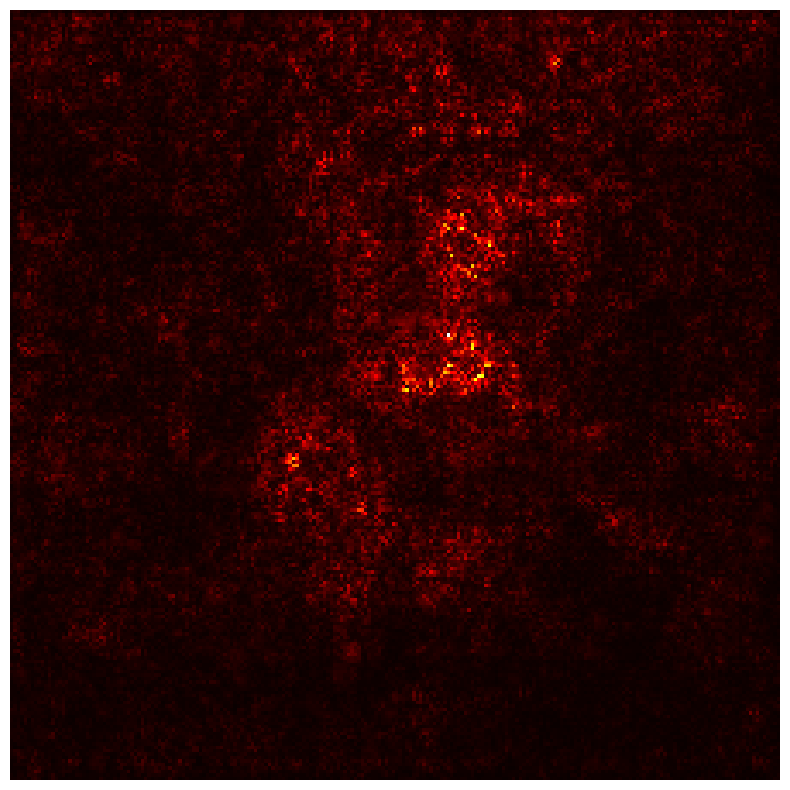

In [126]:
img = Image.open("/mnt/c/Users/janos/OneDrive/Desktop/Master_thesis/puppy.jpg").convert('RGB')
color = saliency(img,model)

In [112]:
color.shape

(224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


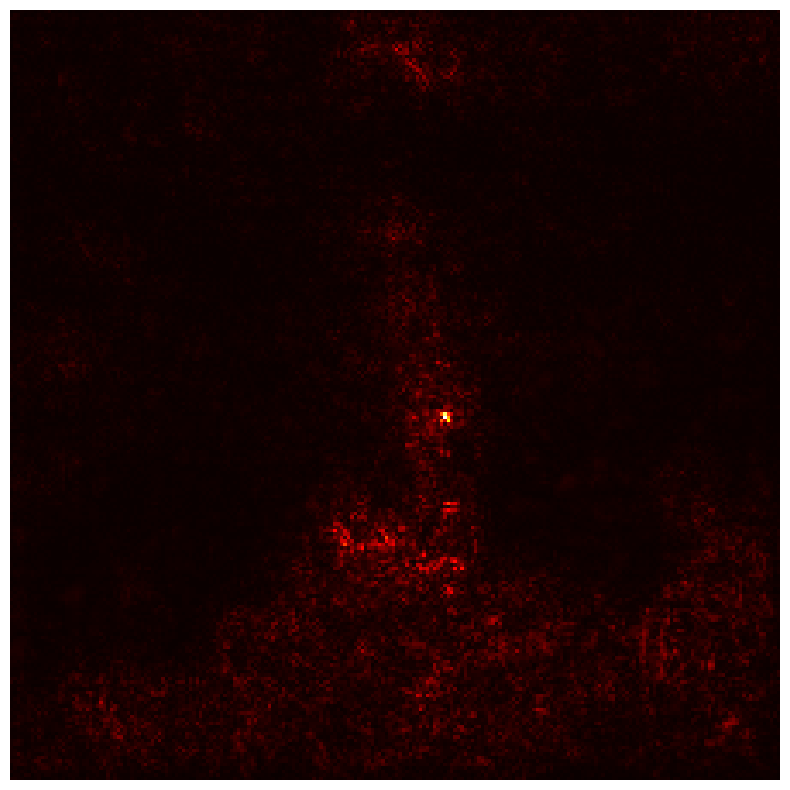

In [12]:
i = Image.open(X[1]).convert('RGB')
a = saliency(i,model)

In [14]:
os.chdir("/mnt/c/Users/janos/OneDrive/Desktop/Master_thesis")

In [21]:
chunk = 10
i=0
import pandas as pd
for df in pd.read_csv('X_matrix.csv',chunksize = chunk):
    X = df
    i=i+1
    if i == 1:
        break

In [78]:
X.iloc[0,0:-1].to_numpy().shape

(50176,)

In [80]:
np.reshape(X.iloc[0,0:-1].to_numpy(),(224,224))

array([[0.        , 0.03236006, 0.0844754 , ..., 0.0755864 , 0.03316216,
        0.0230871 ],
       [0.02688713, 0.05491325, 0.0694285 , ..., 0.08447111, 0.02022943,
        0.05446381],
       [0.06596874, 0.04617579, 0.10137339, ..., 0.01872364, 0.07340507,
        0.02865692],
       ...,
       [0.00329019, 0.04404965, 0.06060703, ..., 0.02077999, 0.01575705,
        0.00425505],
       [0.00533762, 0.08634578, 0.15550148, ..., 0.01122384, 0.00451714,
        0.01667602],
       [0.01614453, 0.02767347, 0.09904625, ..., 0.01657893, 0.00760317,
        0.01944303]])

(-0.5, 223.5, 223.5, -0.5)

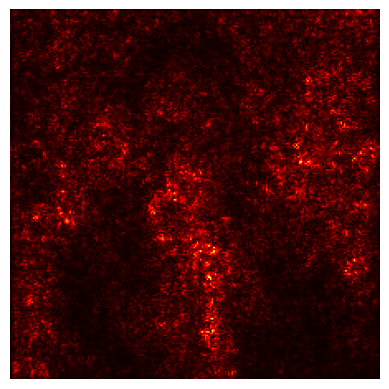

In [91]:
from PIL import Image
plt.imshow(np.reshape(X.iloc[0,0:-1].to_numpy(),(224,224)), cmap=plt.cm.hot)
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


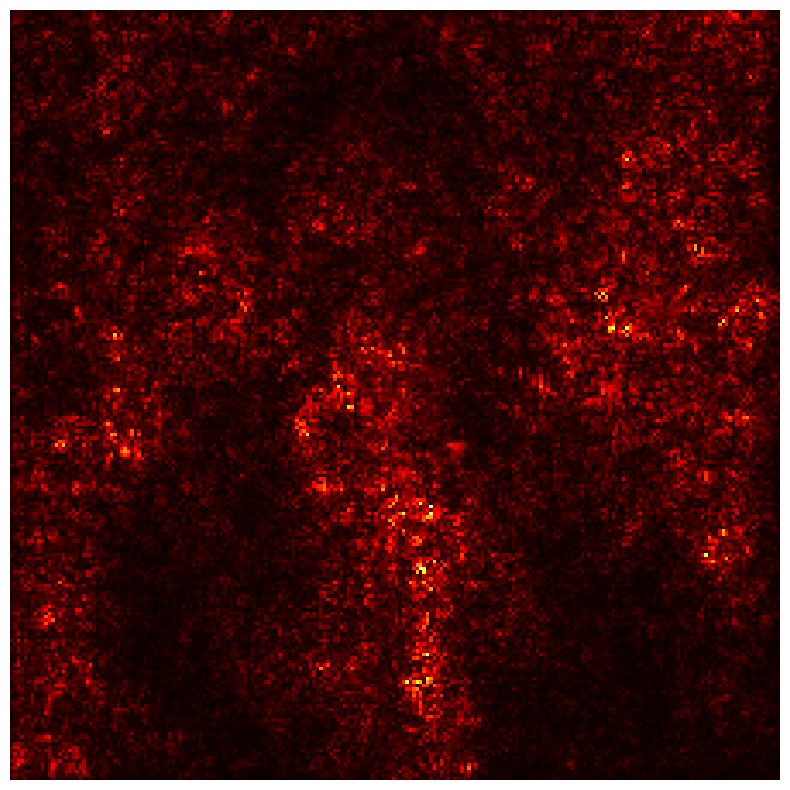

In [90]:
i=0
for x in train_mscoco['Filename']:
    saliency(Image.open(x).convert('RGB'),model)
    i=i+1
    if i == 1:
        break



**Note:**

The annotations are stored in a struct within a .mat file. There exists a pytorch implementation, that stores .py file which transform the mat files into csv files. Please follow this [link](https://github.com/Tandon-A/emotic) to the respective github repository. After I assembled the images and annotations in the demanded structure, I ran the mat2py file and ended up with a training, validation and test csv file.


In [82]:
os.chdir('/mnt/c/Users/janos/OneDrive/Desktop/Master_thesis/kosti/mat2csv/emotic_pre/')

In [83]:
os.listdir()

['test.csv', 'train.csv', 'val.csv']

We will now inspect the 'train.csv' file.

In [84]:
import pandas as pd
train = pd.read_csv('train.csv')

In [85]:
train['Folder'].unique()

array(['mscoco/images', 'emodb_small/images', 'framesdb/images',
       'ade20k/images'], dtype=object)

In [86]:
train[train['Folder']=='mscoco/images']

,Index,Folder,Filename,Image Size,BBox,Categorical_Labels,Continuous_Labels,Gender,Age
0,0,mscoco/images,COCO_val2014_000000562243.jpg,"[640, 640]","[86, 58, 564, 628]","['Disconnection', 'Doubt/Confusion']","[5, 3, 9]",Male,Adult
1,1,mscoco/images,COCO_train2014_000000288841.jpg,"[640, 480]","[485, 149, 605, 473]",['Anticipation'],"[6, 4, 7]",Male,Adult
2,2,mscoco/images,COCO_val2014_000000558171.jpg,"[640, 480]","[305, 92, 461, 465]","['Engagement', 'Excitement', 'Happiness']","[7, 8, 8]",Male,Teenager
3,3,mscoco/images,COCO_train2014_000000369575.jpg,"[480, 640]","[221, 63, 448, 372]","['Aversion', 'Pleasure']","[8, 9, 8]",Male,Kid
4,4,mscoco/images,COCO_train2014_000000213009.jpg,"[500, 333]","[44, 143, 150, 288]","['Confidence', 'Excitement']","[7, 9, 10]",Male,Adult
...,...,...,...,...,...,...,...,...,...
23260,23260,mscoco/images,COCO_val2014_000000203781.jpg,"[640, 480]","[285, 83, 405, 432]",['Sympathy'],"[6, 5, 8]",Male,Teenager
23261,23261,mscoco/images,COCO_train2014_000000175368.jpg,"[500, 375]","[214, 48, 340, 326]",['Confidence'],"[7, 8, 7]",Male,Adult
23262,23262,mscoco/images,COCO_val2014_000000514083.jpg,"[640, 480]","[166, 35, 341, 401]","['Anticipation', 'Engagement', 'Excitement']","[6, 2, 10]",Male,Adult
23264,23264,mscoco/images,COCO_val2014_000000244665.jpg,"[640, 480]","[189, 169, 314, 410]",['Sympathy'],"[6, 4, 8]",Female,Adult


Save saliency maps to .jpg for CNN

In [87]:
train_mscoco = train[train['Folder'] == 'mscoco/images']

In [88]:
os.chdir('/mnt/c/Users/janos/OneDrive/Desktop/Master_thesis/kosti/mat2csv/emotic/mscoco/images')

In [ ]:
train_mscoco = train_mscoco[4419:-1]

In [ ]:
import os

In [ ]:
os.chdir("/mnt/c/Users/janos/OneDrive/Desktop/Master_thesis/saliency_images")

In [ ]:
import 

Kernel died at image 2936, thus the index is manually adapted.

In [ ]:
image = 4419
for x in train_mscoco['Filename']:
    saliency(Image.open(x).convert('RGB'), model);
    plt.savefig("/mnt/c/Users/janos/OneDrive/Desktop/Master_thesis/saliency_images/Saliency_map_No_{im}.jpg"
                .format(im=image));
    print('read image {im}/{length}'.format(im=image,length=len(train_mscoco['Filename'])))
    image=image+1
    

In [ ]:
os.chdir('/mnt/c/Users/janos/OneDrive/Desktop/Master_thesis/kosti/mat2csv/emotic/framesdb/images')
#X = []
#i=0

for image, x in enumerate(train_frames['Filename']):
    sm = saliency(Image.open(x).convert('RGB'), model)
    sm.save('/mnt/c/Users/janos/OneDrive/Desktop/Master_thesis/saliency_images', 'J')
    
    print('Currently saves n_ = {i}'.format(i=image))

In [ ]:
len(X)

In [ ]:
X[0].shape

In [ ]:
X = np.array(X)

In [ ]:
X.shape

In [ ]:
X = np.reshape(X,(7348,50176))

In [ ]:
X_df = pd.DataFrame(X)

In [ ]:
os.chdir('/mnt/c/Users/janos/Onedrive/Desktop/Master_thesis')
X_df.to_csv('X_frames.csv')

CLEANING NEEDED!!!

In [ ]:
y = []
i=0
for x in train_mscoco['Continuous_Labels']:
    y.append(x)
    if i == 100:
        break

In [ ]:
train_mscoco['Continuous_Labels'].shape

In [ ]:
import re

In [ ]:
A = []
for idx, label in enumerate(y):
    s = (re.sub(r"[\[\]]",'',y[idx]))
    for i, x in enumerate(s):
        A.append(x)
        if x == ',':
            A.remove(x)
        if x == ' ':
            A.remove(x)
        try:
            if x == '1' and s[i+1] == '0':
                A.remove(x)
                A.append('10')
        except IndexError:
            continue
        

In [ ]:
for idx, el in enumerate(A):
    if el == '10':
        if A[idx+1] == '0':
            A.remove(A[idx+1])

In [ ]:
len(A)

In [ ]:
cont_labels = []
for val in A:
    cont_labels.append(float(val))

In [ ]:
img = 0
Arousal = []
Valence = []
Dominance = []
for val in cont_labels:
    if img == 0:
        Arousal.append(val)
        img = img+1
        continue
    if img == 1:
        Valence.append(val)
        img = img+1
        continue 
    if img == 2:
        Dominance.append(val)
        img = 0
        continue
    

In [ ]:
Arousal = np.array(Arousal)

In [ ]:
Arousal.shape

In [ ]:
Valence = np.array(Valence)

In [ ]:
Dominance = np.array(Dominance)

**NOTE:**

No idea if this cell below is needed.

for img, tensor in enumerate(X):
    X[img] = X[img].numpy()

## Evaluation of X. PCA and Correlation matrix 

In [ ]:
X = np.array(X)

In [ ]:
X.shape

In [ ]:
X = np.reshape(X,(14276,50176))

**Saving array to csv file for reloading purposes**

In [ ]:
X_df = pd.DataFrame(X)

In [ ]:
os.chdir('/mnt/c/Users/janos/Onedrive/Desktop/Master_thesis')
X_df.to_csv('X_matrix.csv')

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA() #n_components = 10
pca.fit(X)

In [ ]:
plt.plot(pca.explained_variance_ratio_)

In [ ]:
X_transform = pca.transform(X)

In [ ]:
corr =np.corrcoef(X_transform)
plt.matshow(corr, cmap='coolwarm')
plt.colorbar()
plt.xlabel('Samples')
plt.ylabel('Samples')

In [ ]:
corr =np.corrcoef(X)
plt.matshow(corr, cmap='coolwarm')
plt.colorbar()
plt.xlabel('Samples')
plt.ylabel('Samples')

Features are not really correlated

In [ ]:
from sklearn.feature_selection import SelectKBest

In [ ]:
y = Arousal

In [ ]:
import matplotlib.pyplot as plt

plt.hist(Arousal);
plt.title('Distribution of arousal')

In [ ]:
X_new = SelectKBest(k=14275).fit_transform(X, y)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(X_new,y, train_size = 0.8, random_state = 42)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train = scaler.fit_transform(X_train)

In [ ]:
logreg = LogisticRegression(C=10,multi_class = 'ovr')

In [ ]:
logreg.fit(X_train,y_train)

In [ ]:
y_train

In [ ]:
y_pred_train = logreg.predict(X_train)

In [ ]:
logreg.score(X_train,y_train)

In [ ]:
logreg.score(scaler.transform(X_test),y_test)

In [ ]:
y_pred_train

In [ ]:
y_pred_test = logreg.predict(scaler.transform(X_test))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred_train))

In [ ]:
print(classification_report(y_test,y_pred_test))

BARPLOT categories & continous (count)

Model structure!

Google colab

## SVM SETUP

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf = SVC(gamma = 1,C = 0.1, kernel='linear') # Linear Kernel

clf.fit(X_train, y_train)

y_pred_svm = clf.predict(X_train)
print(classification_report(y_train_svm, y_pred_svm))

In [ ]:
print(classification_report(y_train, y_pred_svm))

In [ ]:
print(classification_report(y_test,clf.predict(scaler.transform(X_test))))

## Gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','poly','rbf','sigmoid']}

In [ ]:
grid = GridSearchCV(SVC(), param_grid,cv = 3,refit = True,verbose = 2)
# fitting the model for grid search
grid.fit(X_train, y_train)

In [ ]:
#print best parameter after tuning
print(grid.best_params_)
  # print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [ ]:
print('commit')

In [ ]:
grid_predictions = grid.predict(X_train)
  
# print classification report
print(classification_report(y_train, grid_predictions))